# Data Science Project


## Part A — Python & Data Handling

In [1]:
# Load the dataset and inspect
import pandas as pd
import numpy as np
import os
import math
import time
print("libraries imported")


libraries imported


In [2]:
df = pd.read_csv('cust_satisfaction.csv')
df

,Gender,Customer Type,Type of Travel,Class,satisfaction,Age,Flight Distance,Inflight entertainment,Baggage handling,Cleanliness,Departure Delay in Minutes,Arrival Delay in Minutes
0,Male,Loyal Customer,Personal Travel,Eco Plus,neutral or dissatisfied,13,460,5,4,5,25,18.0
1,Male,disloyal Customer,Business travel,Business,neutral or dissatisfied,25,235,1,3,1,1,6.0
2,Female,Loyal Customer,Business travel,Business,satisfied,26,1142,5,4,5,0,0.0
3,Female,Loyal Customer,Business travel,Business,neutral or dissatisfied,25,562,2,3,2,11,9.0
4,Male,Loyal Customer,Business travel,Business,satisfied,61,214,3,4,3,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
103899,Female,disloyal Customer,Business travel,Eco,neutral or dissatisfied,23,192,2,4,2,3,0.0
103900,Male,Loyal Customer,Business travel,Business,satisfied,49,2347,5,5,4,0,0.0
103901,Male,disloyal Customer,Business travel,Business,neutral or dissatisfied,30,1995,4,4,4,7,14.0
103902,Female,disloyal Customer,Business travel,Eco,neutral or dissatisfied,22,1000,1,1,1,0,0.0


In [3]:
df.shape

(103904, 12)

In [4]:
df.head(5)

,Gender,Customer Type,Type of Travel,Class,satisfaction,Age,Flight Distance,Inflight entertainment,Baggage handling,Cleanliness,Departure Delay in Minutes,Arrival Delay in Minutes
0,Male,Loyal Customer,Personal Travel,Eco Plus,neutral or dissatisfied,13,460,5,4,5,25,18.0
1,Male,disloyal Customer,Business travel,Business,neutral or dissatisfied,25,235,1,3,1,1,6.0
2,Female,Loyal Customer,Business travel,Business,satisfied,26,1142,5,4,5,0,0.0
3,Female,Loyal Customer,Business travel,Business,neutral or dissatisfied,25,562,2,3,2,11,9.0
4,Male,Loyal Customer,Business travel,Business,satisfied,61,214,3,4,3,0,0.0


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 103904 entries, 0 to 103903
Data columns (total 12 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   Gender                      103904 non-null  object 
 1   Customer Type               103904 non-null  object 
 2   Type of Travel              103904 non-null  object 
 3   Class                       103904 non-null  object 
 4   satisfaction                103904 non-null  object 
 5   Age                         103904 non-null  int64  
 6   Flight Distance             103904 non-null  int64  
 7   Inflight entertainment      103904 non-null  int64  
 8   Baggage handling            103904 non-null  int64  
 9   Cleanliness                 103904 non-null  int64  
 10  Departure Delay in Minutes  103904 non-null  int64  
 11  Arrival Delay in Minutes    103594 non-null  float64
dtypes: float64(1), int64(6), object(5)
memory usage: 9.5+ MB


In [6]:
# Heuristics to pick a target column for classification
# 1) look for common target-like names, 2) look for binary/categorical columns, 3) fallback: create binary from a numeric satisfaction score if available, else binarize first numeric column by median.
col_lower = [c.lower() for c in df.columns]
target_candidates = []
for i,c in enumerate(df.columns):
    name = c.lower()
    if any(k in name for k in ['target','churn','label','satisfaction','status','y','response']):
        target_candidates.append(c)

# find categorical/binary columns
binary_cols = [c for c in df.columns if df[c].nunique()<=5 and df[c].dtype!='float64' and df[c].dtype!='int64']
if not target_candidates:
    # check for explicit binary-like columns
    for c in df.columns:
        if df[c].nunique()<=2:
            target_candidates.append(c)
            
chosen_target = None
reason = ''
if target_candidates:
    chosen_target = target_candidates[0]
    reason = f'Picked candidate by name or low cardinality: {chosen_target}'
else:
    # fallback: look for numeric column with 'satisf' in name
    found = None
    for c in df.columns:
        if 'satisf' in c.lower() or 'score' in c.lower() or 'rating' in c.lower():
            found = c; break
    if found:
        chosen_target = found
        reason = f'No explicit target found — using numeric column {found} as target (will binarize by median).'
    else:
        # fallback: pick first numeric column
        num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
        if num_cols:
            chosen_target = num_cols[0]
            reason = f'No explicit or satisfaction-like column — using first numeric column {chosen_target} as target (will binarize by median).'
        else:
            reason = 'No usable numeric column found; classification steps may fail.'

print('Chosen target:', chosen_target)
print('Reason:', reason)
print('\nTarget value counts (if present):')
try:
    print(df[chosen_target].value_counts(dropna=False))
except Exception as e:
    print('Could not show value counts:', e)

Chosen target: Customer Type
Reason: Picked candidate by name or low cardinality: Customer Type

Target value counts (if present):
Customer Type
Loyal Customer       84923
disloyal Customer    18981
Name: count, dtype: int64


In [7]:
df.size

1246848

In [8]:
df.duplicated().sum()

172

In [9]:
df.drop_duplicates(inplace=True)

In [10]:
df.size

1244784

In [11]:
df.isnull().sum()

Gender                          0
Customer Type                   0
Type of Travel                  0
Class                           0
satisfaction                    0
Age                             0
Flight Distance                 0
Inflight entertainment          0
Baggage handling                0
Cleanliness                     0
Departure Delay in Minutes      0
Arrival Delay in Minutes      310
dtype: int64

In [12]:
df.dropna(inplace=True)

In [13]:
# Implement mean, median, mode WITHOUT numpy.mean or pandas.DataFrame.mean
def my_mean(arr):
    total = 0.0
    count = 0
    for v in arr:
        if v is None or (isinstance(v, float) and np.isnan(v)):
            continue
        total += float(v)
        count += 1
    return total / count if count else float('nan')

def my_median(arr):
    vals = [float(v) for v in arr if not (isinstance(v, float) and np.isnan(v))]
    if not vals:
        return float('nan')
    vals.sort()
    m = len(vals)//2
    if len(vals) % 2 == 1:
        return vals[m]
    else:
        return (vals[m-1] + vals[m]) / 2.0

def my_mode(arr):
    vals = [v for v in arr if not (isinstance(v, float) and np.isnan(v))]
    if not vals:
        return None
    counts = Counter(vals)
    top = counts.most_common()
    max_count = top[0][1]
    modes = [val for val,count in top if count == max_count]
    return sorted(modes)[0]

# Demonstrate on numeric columns
for c in num_cols[:5]:
    print(f'Column: {c}')
    try:
        print(' my_mean:', my_mean(df_clean[c]))
        print(' pandas_mean:', df_clean[c].mean())
        print(' my_median:', my_median(df_clean[c]))
        print(' pandas_median:', df_clean[c].median())
        print(' my_mode (approx):', my_mode(df_clean[c]))
        print()
    except Exception as e:
        print(' error on column:', e)

NameError: name 'num_cols' is not defined

In [ ]:
# Min-max normalization and Pearson correlation matrix WITHOUT pandas.corr
def min_max_scale(series):
    arr = np.array(series, dtype=float)
    mn = arr.min()
    mx = arr.max()
    if mx == mn:
        return np.zeros_like(arr)
    return (arr - mn) / (mx - mn)

def pearson_corr_matrix(df, cols):
    data = {c: np.array(df[c], dtype=float) for c in cols}
    n = len(cols)
    mat = np.zeros((n,n))
    for i in range(n):
        xi = data[cols[i]]
        for j in range(n):
            xj = data[cols[j]]
            xi_mean = xi.mean()
            xj_mean = xj.mean()
            num = ((xi - xi_mean)*(xj - xj_mean)).sum()
            den = np.sqrt(((xi - xi_mean)**2).sum() * ((xj - xj_mean)**2).sum())
            mat[i,j] = num/den if den != 0 else 0.0
    return pd.DataFrame(mat, index=cols, columns=cols)

numeric_for_corr = num_cols[:10]  # use up to first 10 numeric columns
if numeric_for_corr:
    corr_df = pearson_corr_matrix(df_clean, numeric_for_corr)
    display(corr_df)
else:
    print('No numeric columns for correlation matrix.')

,Age,Flight Distance,Inflight entertainment,Baggage handling,Cleanliness,Departure Delay in Minutes,Arrival Delay in Minutes
Age,1.000000,0.099670,0.076230,-0.047789,0.053592,-0.008564,-0.011673
Flight Distance,0.099670,1.000000,0.129042,0.063430,0.093404,0.001537,-0.007024
Inflight entertainment,0.076230,0.129042,1.000000,0.378138,0.691641,-0.030799,-0.041644
Baggage handling,-0.047789,0.063430,0.378138,1.000000,0.095650,-0.016188,-0.027994
Cleanliness,0.053592,0.093404,0.691641,0.095650,1.000000,-0.021088,-0.031665
Departure Delay in Minutes,-0.008564,0.001537,-0.030799,-0.016188,-0.021088,1.000000,0.838110
Arrival Delay in Minutes,-0.011673,-0.007024,-0.041644,-0.027994,-0.031665,0.838110,1.000000


In [ ]:
# Runtime comparisons: my_mean/my_median vs pandas/numpy (timing)
import timeit
setup_code = """from __main__ import my_mean, my_median, df_clean, np"""
timings = {}
if num_cols:
    col = num_cols[0]
    timings['my_mean'] = timeit.timeit(f"my_mean(df_clean['{col}'])", setup=setup_code, number=10)
    timings['pandas_mean'] = timeit.timeit(f"df_clean['{col}'].mean()", setup=setup_code, number=10)
    timings['my_median'] = timeit.timeit(f"my_median(df_clean['{col}'])", setup=setup_code, number=10)
    timings['pandas_median'] = timeit.timeit(f"df_clean['{col}'].median()", setup=setup_code, number=10)
    display(timings)
else:
    print('No numeric columns to time.')

{'my_mean': 0.18870229995809495,
 'pandas_mean': 0.0008431000169366598,
 'my_median': 0.28886279999278486,
 'pandas_median': 0.017274299985729158}

## Part B — Exploratory Data Analysis & Visualizations

In [ ]:
import matplotlib.pyplot as plt

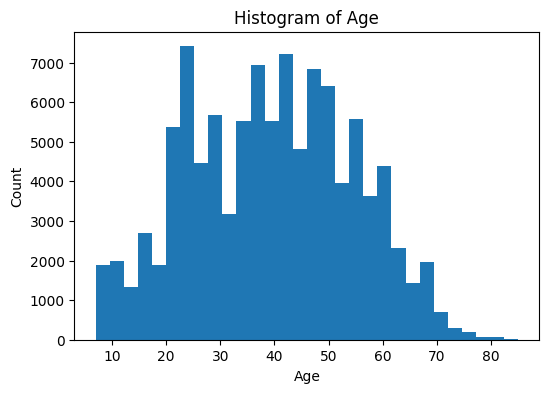

In [ ]:
# 1: Histogram for first numeric column
if num_cols:
    plt.figure(figsize=(6,4))
    plt.hist(df_clean[num_cols[0]].dropna(), bins=30)
    plt.title(f'Histogram of {num_cols[0]}')
    plt.xlabel(num_cols[0]); plt.ylabel('Count')
    plt.show()

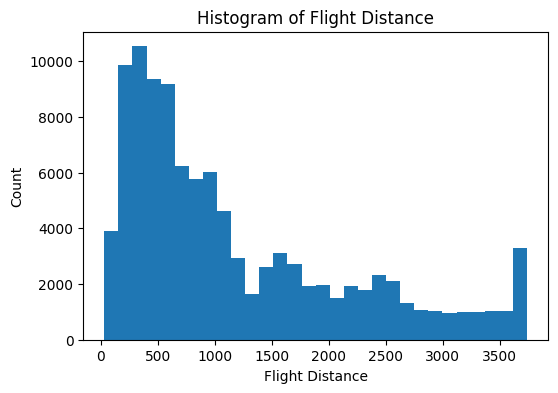

In [ ]:
# 2: Histogram for second numeric column (if exists)
if len(num_cols) > 1:
    plt.figure(figsize=(6,4))
    plt.hist(df_clean[num_cols[1]].dropna(), bins=30)
    plt.title(f'Histogram of {num_cols[1]}')
    plt.xlabel(num_cols[1]); plt.ylabel('Count')
    plt.show()

C:\Users\ayush\AppData\Local\Temp\ipykernel_59848\2827815683.py:8: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(groups, labels=labels)


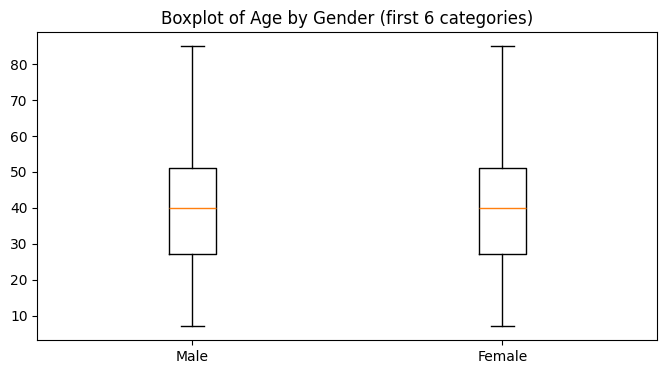

In [ ]:
# 3: Boxplot of a numeric column grouped by a categorical column (if exists)
cat_cols = df_clean.select_dtypes(include=['object','category']).columns.tolist()
if num_cols and cat_cols:
    coln = num_cols[0]; catn = cat_cols[0]
    groups = [df_clean[df_clean[catn]==g][coln].dropna() for g in df_clean[catn].unique()[:6]]
    labels = list(df_clean[catn].unique())[:6]
    plt.figure(figsize=(8,4))
    plt.boxplot(groups, labels=labels)
    plt.title(f'Boxplot of {coln} by {catn} (first 6 categories)')
    plt.show()
else:
    print('Skipping grouped boxplot (no categorical column present).')

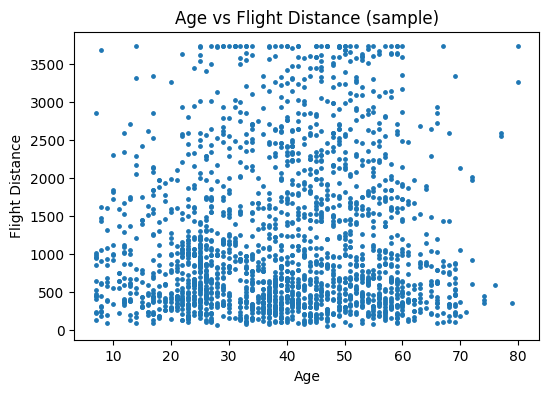

In [ ]:
# 4: Scatter plot for two numeric columns (if available)
if len(num_cols) >= 2:
    plt.figure(figsize=(6,4))
    plt.scatter(df_clean[num_cols[0]].sample(min(2000,len(df_clean)), random_state=1), df_clean[num_cols[1]].sample(min(2000,len(df_clean)), random_state=1), s=6)
    plt.xlabel(num_cols[0]); plt.ylabel(num_cols[1]); plt.title(f'{num_cols[0]} vs {num_cols[1]} (sample)')
    plt.show()


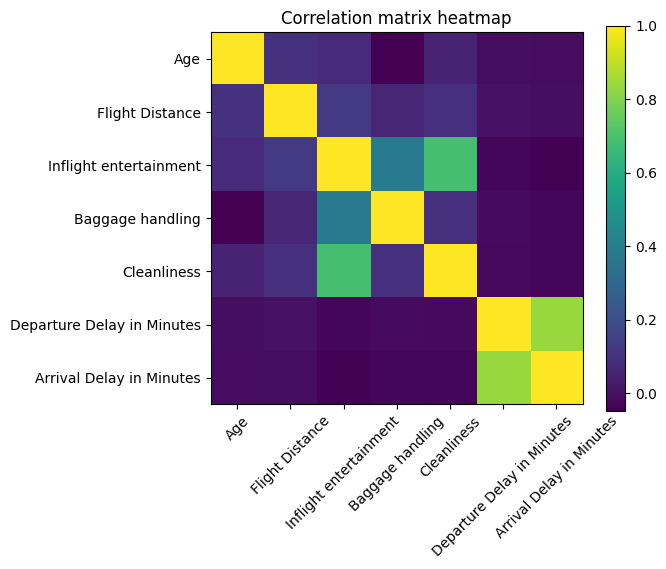

In [ ]:
# 5: Correlation heatmap for numeric_for_corr
if 'corr_df' in globals():
    plt.figure(figsize=(6,5))
    plt.imshow(corr_df.values, interpolation='nearest')
    plt.xticks(range(len(corr_df.columns)), corr_df.columns, rotation=45)
    plt.yticks(range(len(corr_df.index)), corr_df.index)
    plt.colorbar(); plt.title('Correlation matrix heatmap')
    plt.show()

In [ ]:
# Quick automated findings (basic)
print('Number of rows, columns:', df_clean.shape)
print('\nTop 5 numeric columns by variance:')
if num_cols:
    var_sorted = sorted(num_cols, key=lambda c: df_clean[c].var() if c in df_clean else 0, reverse=True)
    print(var_sorted[:5])
else:
    print('No numeric columns')

Number of rows, columns: (103732, 12)

Top 5 numeric columns by variance:
['Flight Distance', 'Age', 'Arrival Delay in Minutes', 'Departure Delay in Minutes', 'Inflight entertainment']


## Part C — Machine Learning (Classical + Evaluation)

In [ ]:
# # Prepare X and y for classification
# from sklearn.model_selection import train_test_split, cross_validate
# from sklearn.preprocessing import OneHotEncoder, StandardScaler
# from sklearn.compose import ColumnTransformer
# from sklearn.pipeline import Pipeline
# from sklearn.ensemble import RandomForestClassifier
# from sklearn.linear_model import LogisticRegression
# from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, classification_report

# df_ml = df_clean.copy()

# # Choose y column and prepare
# y_col = chosen_target
# if y_col is None:
#     raise RuntimeError('No target column identified for classification.')

# # If y is numeric and has many unique values, binarize by median
# if np.issubdtype(df_ml[y_col].dtype, np.number) and df_ml[y_col].nunique() > 10:
#     med = df_ml[y_col].median()
#     df_ml['_y_bin_'] = (df_ml[y_col] > med).astype(int)
#     y_col_used = '_y_bin_'
#     print(f'Numeric target {y_col} binarized by median -> _y_bin_')
# else:
#     # if categorical, encode small number of categories as integers
#     if df_ml[y_col].dtype == 'object' or df_ml[y_col].nunique()<=20:
#         df_ml[y_col] = df_ml[y_col].astype(str)
#     # if more than 20 categories, try binarize first numeric instead
#     if df_ml[y_col].nunique() > 20 and np.issubdtype(df_ml[y_col].dtype, np.number):
#         med = df_ml[y_col].median()
#         df_ml['_y_bin_'] = (df_ml[y_col] > med).astype(int)
#         y_col_used = '_y_bin_'
#     else:
#         y_col_used = y_col

# print('Using target column for ML:', y_col_used)
# X = df_ml.drop(columns=[y_col_used])
# y = df_ml[y_col_used]

# # Simple preprocessing: numeric scaler, one-hot for categorical (limit categories)
# numeric_features = X.select_dtypes(include=[np.number]).columns.tolist()
# categorical_features = X.select_dtypes(include=['object','category']).columns.tolist()

# # Build pipeline
# preprocessor = ColumnTransformer(transformers=[
#     ('num', StandardScaler(), numeric_features),
#     ('cat', OneHotEncoder(handle_unknown='ignore', sparse=False), categorical_features)
# ], remainder='drop')

# def build_and_evaluate(clf, name):
#     pipe = Pipeline([('pre', preprocessor), ('clf', clf)])
#     X_train, X_test, y_train, y_test = train_test_split(
#         X, y, test_size=0.2, random_state=42,
#         stratify=y if y.nunique() > 1 else None
#     )
#     pipe.fit(X_train, y_train)
#     y_pred = pipe.predict(X_test)

#     # Try probability or decision_function
#     y_proba = None
#     if hasattr(pipe.named_steps['clf'], 'predict_proba'):
#         try:
#             y_proba = pipe.predict_proba(X_test)
#         except Exception:
#             pass
#     elif hasattr(pipe.named_steps['clf'], 'decision_function'):
#         scores = pipe.decision_function(X_test)
#         if scores.ndim == 1:
#             y_proba = (scores - scores.min()) / (scores.max() - scores.min() + 1e-12)

#     print(f'\n---- {name} ----')
#     print('Accuracy:', accuracy_score(y_test, y_pred))

#     # ✅ Handle binary vs multiclass
#     avg_type = 'binary' if y.nunique() == 2 and sorted(y.unique()) in [[0,1],[1,0]] else 'weighted'
#     print('Precision:', precision_score(y_test, y_pred, average=avg_type, zero_division=0))
#     print('Recall:', recall_score(y_test, y_pred, average=avg_type, zero_division=0))
#     print('F1:', f1_score(y_test, y_pred, average=avg_type, zero_division=0))

#     print('\nClassification report:\n', classification_report(y_test, y_pred, zero_division=0))

#     # ✅ Only show ROC AUC if it's binary
#     if y_proba is not None and y.nunique() == 2:
#         try:
#             if y_proba.ndim > 1:
#                 y_scores = y_proba[:, 1]
#             else:
#                 y_scores = y_proba
#             roc = roc_auc_score(y_test, y_scores)
#             print('ROC AUC:', roc)
#             fpr, tpr, _ = roc_curve(y_test, y_scores)
#             import matplotlib.pyplot as plt
#             plt.figure(figsize=(5, 4))
#             plt.plot(fpr, tpr, label=f'{name} (AUC={roc:.2f})')
#             plt.plot([0, 1], [0, 1], '--')
#             plt.legend()
#             plt.title(f'ROC curve ({name})')
#             plt.xlabel('False Positive Rate')
#             plt.ylabel('True Positive Rate')
#             plt.show()
#         except Exception as e:
#             print('Could not compute ROC AUC:', e)


# # Train Random Forest
# rf = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
# build_and_evaluate(rf, 'Random Forest')

# # Train Logistic Regression (with max_iter increased)
# lr = LogisticRegression(max_iter=1000)
# build_and_evaluate(lr, 'Logistic Regression')

# # Cross-validation summaries
# print('\nCross-validation (Random Forest):')
# cv = cross_validate(Pipeline([('pre', preprocessor), ('clf', rf)]), X, y, cv=5, scoring=['accuracy','precision','recall','f1'])
# print({k: v.mean() for k,v in cv.items() if k.startswith('test_')})

Using target column for ML: satisfaction


c:\Users\ayush\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\preprocessing\_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(



---- Random Forest ----
Accuracy: 0.8729454860943751
Precision: 0.8741354081025178
Recall: 0.8729454860943751
F1: 0.8719973903318742

Classification report:
                          precision    recall  f1-score   support

neutral or dissatisfied       0.86      0.92      0.89     11764
              satisfied       0.89      0.81      0.85      8983

               accuracy                           0.87     20747
              macro avg       0.88      0.86      0.87     20747
           weighted avg       0.87      0.87      0.87     20747

ROC AUC: 0.9199803830598756
Could not compute ROC AUC: y_true takes value in {'neutral or dissatisfied', 'satisfied'} and pos_label is not specified: either make y_true take value in {0, 1} or {-1, 1} or pass pos_label explicitly.


c:\Users\ayush\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\preprocessing\_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(



---- Logistic Regression ----
Accuracy: 0.8389164698510628
Precision: 0.8386605173996295
Recall: 0.8389164698510628
F1: 0.8387391322048945

Classification report:
                          precision    recall  f1-score   support

neutral or dissatisfied       0.85      0.86      0.86     11764
              satisfied       0.82      0.81      0.81      8983

               accuracy                           0.84     20747
              macro avg       0.84      0.83      0.84     20747
           weighted avg       0.84      0.84      0.84     20747

ROC AUC: 0.8963107777004302
Could not compute ROC AUC: y_true takes value in {'neutral or dissatisfied', 'satisfied'} and pos_label is not specified: either make y_true take value in {0, 1} or {-1, 1} or pass pos_label explicitly.

Cross-validation (Random Forest):


c:\Users\ayush\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\preprocessing\_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
c:\Users\ayush\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_validation.py:839: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\ayush\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_scorer.py", line 136, in __call__
    score = scorer._score(
            ^^^^^^^^^^^^^^
  File "c:\Users\ayush\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_scorer.py", line 355, in _score
    return self._sign * self._score_func(y_true, y_pred, **scoring_kwargs)
                        ^^^^^^^^^^^

{'test_accuracy': 0.8697894834896281, 'test_precision': nan, 'test_recall': nan, 'test_f1': nan}


c:\Users\ayush\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_validation.py:839: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\ayush\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_scorer.py", line 136, in __call__
    score = scorer._score(
            ^^^^^^^^^^^^^^
  File "c:\Users\ayush\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_scorer.py", line 355, in _score
    return self._sign * self._score_func(y_true, y_pred, **scoring_kwargs)
                        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\ayush\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\_param_validation.py", line 214, in wrapper
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\ayush\AppData\Local\Programs\Python\Pytho

In [14]:
def build_and_evaluate(clf, name):
    pipe = Pipeline([('pre', preprocessor), ('clf', clf)])
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42,
        stratify=y if y.nunique() > 1 else None
    )
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)

    # Try probability or decision_function
    y_proba = None
    if hasattr(pipe.named_steps['clf'], 'predict_proba'):
        try:
            y_proba = pipe.predict_proba(X_test)
        except Exception:
            pass
    elif hasattr(pipe.named_steps['clf'], 'decision_function'):
        scores = pipe.decision_function(X_test)
        if scores.ndim == 1:
            y_proba = (scores - scores.min()) / (scores.max() - scores.min() + 1e-12)

    print(f'\n---- {name} ----')
    print('Accuracy:', accuracy_score(y_test, y_pred))

    # ✅ Handle binary vs multiclass
    avg_type = 'binary' if y.nunique() == 2 and sorted(y.unique()) in [[0,1],[1,0]] else 'weighted'
    print('Precision:', precision_score(y_test, y_pred, average=avg_type, zero_division=0))
    print('Recall:', recall_score(y_test, y_pred, average=avg_type, zero_division=0))
    print('F1:', f1_score(y_test, y_pred, average=avg_type, zero_division=0))

    print('\nClassification report:\n', classification_report(y_test, y_pred, zero_division=0))

    # ✅ Only show ROC AUC if it's binary
    if y_proba is not None and y.nunique() == 2:
        try:
            if y_proba.ndim > 1:
                y_scores = y_proba[:, 1]
            else:
                y_scores = y_proba
            roc = roc_auc_score(y_test, y_scores)
            print('ROC AUC:', roc)
            fpr, tpr, _ = roc_curve(y_test, y_scores)
            import matplotlib.pyplot as plt
            plt.figure(figsize=(5, 4))
            plt.plot(fpr, tpr, label=f'{name} (AUC={roc:.2f})')
            plt.plot([0, 1], [0, 1], '--')
            plt.legend()
            plt.title(f'ROC curve ({name})')
            plt.xlabel('False Positive Rate')
            plt.ylabel('True Positive Rate')
            plt.show()
        except Exception as e:
            print('Could not compute ROC AUC:', e)


In [15]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import seaborn as sns

# Load dataset
df = pd.read_csv('cust_satisfaction.csv')
df.head()

,Gender,Customer Type,Type of Travel,Class,satisfaction,Age,Flight Distance,Inflight entertainment,Baggage handling,Cleanliness,Departure Delay in Minutes,Arrival Delay in Minutes
0,Male,Loyal Customer,Personal Travel,Eco Plus,neutral or dissatisfied,13,460,5,4,5,25,18.0
1,Male,disloyal Customer,Business travel,Business,neutral or dissatisfied,25,235,1,3,1,1,6.0
2,Female,Loyal Customer,Business travel,Business,satisfied,26,1142,5,4,5,0,0.0
3,Female,Loyal Customer,Business travel,Business,neutral or dissatisfied,25,562,2,3,2,11,9.0
4,Male,Loyal Customer,Business travel,Business,satisfied,61,214,3,4,3,0,0.0


In [16]:
# Handle missing values
df['Arrival Delay in Minutes'].fillna(df['Arrival Delay in Minutes'].median(), inplace=True)

# Encode categorical variables
cat_cols = df.select_dtypes(include=['object']).columns
le = LabelEncoder()
for col in cat_cols:
    df[col] = le.fit_transform(df[col])

# Features & target
X = df.drop('satisfaction', axis=1)
y = df['satisfaction']

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Scale numerical features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

C:\Users\ayush\AppData\Local\Temp\ipykernel_54004\1664045549.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['Arrival Delay in Minutes'].fillna(df['Arrival Delay in Minutes'].median(), inplace=True)


In [ ]:
# Define models
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'SVM': SVC(probability=True, random_state=42)
}

# Cross-validation setup
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

results = {}

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:,1]
    
    results[name] = {
        'Accuracy': accuracy_score(y_test, y_pred),
        'Precision': precision_score(y_test, y_pred),
        'Recall': recall_score(y_test, y_pred),
        'F1': f1_score(y_test, y_pred),
        'ROC_AUC': roc_auc_score(y_test, y_proba)
    }

results_df = pd.DataFrame(results).T
results_df

In [ ]:
plt.figure(figsize=(8,6))
for name, model in models.items():
    y_proba = model.predict_proba(X_test)[:,1]
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    plt.plot(fpr, tpr, label=f'{name} (AUC={roc_auc_score(y_test, y_proba):.2f})')

plt.plot([0,1], [0,1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves')
plt.legend()
plt.show()